<a href="https://colab.research.google.com/github/Gongsoo/Python3/blob/main/mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import gdown

gdown.download(f"https://drive.google.com/uc?export=download&confirm=pbef&id={'1SCU1cNRmEpGfaA0C0JJSqOgeW3_ukoQB'}",'Face Mask Detection.zip')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1SCU1cNRmEpGfaA0C0JJSqOgeW3_ukoQB
To: /content/Face Mask Detection.zip
100%|██████████| 417M/417M [00:10<00:00, 38.6MB/s]


'Face Mask Detection.zip'

In [8]:
!unzip -q Face\ Mask\ Detection.zip

In [9]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup

from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
import random

In [10]:
img_list = sorted(glob.glob('images/*'))
annot_list = sorted(glob.glob('annotations/*'))

In [80]:
def generate_box(obj) :
  xmin = float(obj.find('xmin').text)
  ymin = float(obj.find('ymin').text)
  xmax = float(obj.find('xmax').text)
  ymax = float(obj.find('ymax').text)
  return [xmin,ymin,xmax,ymax]

def generate_label(obj) :
  if obj.find('name').text == "with_mask" :
    return 1
  elif obj.find('name').text == "mask_weared_incorrect" :
    return 2
  return 0

def generate_target(file) :
  with open(file) as f:
    data = f.read()
    soup = BeautifulSoup(data, "html.parser")
    objects = soup.find_all("object")

    num_objs = len(objects)

    boxes = []
    labels = []
    for i in objects :
      boxes.append(generate_box(i))
      labels.append(generate_label(i))
    

    boxes = torch.as_tensor(boxes, dtype = torch.float32)
    labels = torch.as_tensor(labels, dtype = torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels

    return target

def plot_image(img, annotation) :
  img = img.permute(1,2,0)

  rects = []
  fig,ax = plt.subplots(1)
  ax.imshow(img)
  for idx in range(len(annotation["boxes"])) :
    xmin, ymin, xmax, ymax = annotation["boxes"][idx]

    if annotation["labels"][idx] == 0 :
      rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth = 1, edgecolor='r', facecolor = 'none')
    elif annotation["labels"][idx] == 1 :
      rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth = 1, edgecolor='g', facecolor = 'none')
    else :
      rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth = 1, edgecolor='orange', facecolor = 'none')
    rects.append(rect)
    ax.add_patch(rect)
  plt.show()
  return img, rects

In [88]:
class MaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        target = generate_target(label_path)
        
        to_tensor = torchvision.transforms.ToTensor()

        if self.transform:
            transformed = self.transform(image = image, bboxes = target['boxes'], labels = target['labels'])
            image = transformed['image']
            target = {'boxes':transformed['bboxes'], 'labels':transformed['labels']}

        # tensor로 변경
        image = to_tensor(image)


        return image, target

In [ ]:
class TorchvisionMaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        
        target = generate_target(label_path)
        
        start_t = time.time()
        if self.transform:
            img = self.transform(img)

        total_time = (time.time() - start_t)

        return img, target, total_time

In [16]:
!mkdir test_images
!mkdir test_annotations

In [17]:
random.seed(1234)
idx = random.sample(range(853),170)
import shutil

for img in np.array(sorted(os.listdir('images')))[idx] :
  shutil.move('images/'+img,'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
  shutil.move('annotations/'+annot,'test_annotations/'+annot)

In [92]:
bbox_transform = albumentations.Compose(
    [albumentations.HorizontalFlip(p=1),
     albumentations.Rotate(p=1),
     albumentations.pytorch.transforms.ToTensorV2()],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels']),
)

In [93]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset('images/')
test_dataset = MaskDataset('test_images/')
tran_dataset = MaskDataset(path = 'images/',transform = bbox_transform)
tran_test_dataset = MaskDataset('test_images/',bbox_transform)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)
tran_data_loader = torch.utils.data.DataLoader(tran_dataset, batch_size=4, collate_fn=collate_fn)
tran_test_data_loader = torch.utils.data.DataLoader(tran_test_dataset, batch_size=4, collate_fn=collate_fn)


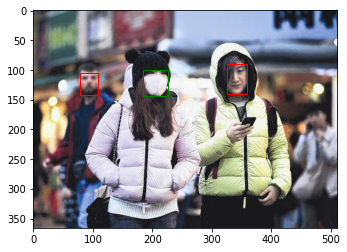

TypeError: ignored

In [96]:
img, annot = dataset[0]
plot_image(img,annot)

print(tran_dataset[0])

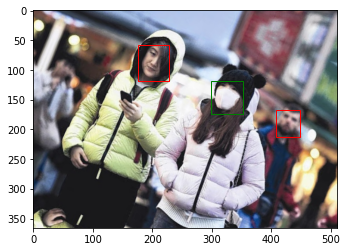

In [ ]:
bbox_transform_dataset = BboxAugmentationDataset(
    path = 'images/',
    transform = bbox_transform
)

img, annot = bbox_transform_dataset[0]
plot_image(img, annot)

In [18]:
from tqdm import tqdm
import pandas as pd
from collections import Counter

def get_num_objects_for_each_class(dataset):

    total_labels = []

    for img, annot in tqdm(dataset, position = 0, leave = True):
        total_labels += [int(i) for i in annot['labels']]

    return Counter(total_labels)


train_data =  BboxAugmentationDataset(
    path = 'images/'
)

test_data =  BboxAugmentationDataset(
    path = 'test_images/'
)

train_objects = get_num_objects_for_each_class(train_data)
test_objects = get_num_objects_for_each_class(test_data)

print('\n train 데이터에 있는 객체', train_objects)
print('\n test 데이터에 있는 객체', test_objects)

NameError: ignored

In [ ]:
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes=3, pretrained = False, pretrained_backbone = True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to pass

  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
from tqdm import tqdm
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

num_epochs = 10
retina.to(device)

params = [p for p in retina.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0001,weight_decay = 0.00001)

len_dataloader = len(data_loader)

for epoch in range(num_epochs) :
  retina.train()
  i = 0
  epoch_loss = 0
  for images, targets in tqdm(data_loader) :
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

    loss_dict = retina(images, targets)

    losses = sum(loss for loss in loss_dict.values())

    i+=1

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    epoch_loss += losses
  print(epoch_loss)

100%|██████████| 171/171 [04:04<00:00,  1.43s/it]


tensor(114.6525, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 171/171 [04:04<00:00,  1.43s/it]


tensor(79.1635, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 171/171 [04:03<00:00,  1.43s/it]


tensor(67.8345, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 171/171 [04:04<00:00,  1.43s/it]


tensor(58.4584, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 171/171 [04:03<00:00,  1.43s/it]


tensor(53.5594, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 171/171 [04:03<00:00,  1.43s/it]


tensor(49.5613, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 171/171 [04:03<00:00,  1.42s/it]


tensor(52.0420, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 171/171 [04:03<00:00,  1.42s/it]


tensor(43.4332, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 171/171 [04:03<00:00,  1.42s/it]


tensor(42.2942, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 171/171 [04:03<00:00,  1.42s/it]


tensor(35.2514, device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
torch.save(retina.state_dict(),f'retina_mask_{num_epochs}.pt')